In [0]:
import skimage.io
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [0]:
#######################################################
# - อ่านไฟล์ภาพ
# - resize ภาพให้มีขนาด 20x50x3
# - convert จาก RGB เป็น Gray scale
#######################################################

DATASET_DIR = (r'D:\LLPR\simple-car-plate-recognition-master\dataset\Districts')

classes = os.listdir(DATASET_DIR)
data = []

for cls in classes:
  class_dir = os.path.join(DATASET_DIR, cls)
  files = os.listdir(class_dir)
  for f in files:
    img = skimage.io.imread(os.path.join(class_dir, f)) # อ่านพิกเซลของภาพ (พิกเซลมีค่า 0-255)
    img2 = skimage.transform.resize(img, (20,50,3)) # ปรับขนาดภาพเป็น 20x50 พิกเซล (พิกเซลมีค่า 0-1)
    img = skimage.color.rgb2gray(img2) # แปลงเป็น gray scale (พิกเซลมีค่า 0-1)
    #img = skimage.util.invert(img) # กลับค่าสี (optional) (พิกเซลมีค่า 0-1)
    img = (img - img.min())/(img.max() - img.min()) # ปรับยืดความสว่างและมืดของภาพ (พิกเซลมีค่า 0-1)
    data.append({
        'x': img,
        'y': cls
    })
    #print(F'{img.min()}, {img.max()}')
    
random.shuffle(data)

In [0]:
X = [d['x'] for d in data]
y = [d['y'] for d in data]

# เพิ่มข้อมูลที่มีการรบกวน
X.extend([dx + 0.2*np.random.randn(20,50) for dx in X])
y.extend(y)

# สลับภาพหลังจากเพิ่มภาพเติมแต่ง
shf_ind = list(range(len(X)))
random.shuffle(shf_ind)
X = np.array(X)[shf_ind]
y = np.array(y)[shf_ind]


ys = list(np.unique(y))
y = [ys.index(v) for v in y]

x_train = np.array(X[:int(len(X)*0.8)])
y_train = np.array(y[:int(len(X)*0.8)])

x_test = np.array(X[int(len(X)*0.8):])
y_test = np.array(y[int(len(X)*0.8):])

In [0]:
batch_size = 128
num_classes = len(classes)
#num_classes = 13
epochs = 200

# input image dimensions
img_rows, img_cols = 20, 50

In [0]:
num_classes

13

In [0]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# ไม่ต้อง normalize ด้วย 255 แล้ว เพราะค่า x แต่ละพิกเซลมีค่าระหว่าง 0.0 - 1.0
#x_train /= 255
#x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (390, 20, 50, 1)
390 train samples
98 test samples


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 18, 48, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 23, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 23, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 11776)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1507456   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
history = model.fit(x_train, y_train2,
          batch_size=batch_size,
          #epochs=1000,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

Train on 390 samples, validate on 98 samples
Epoch 1/200
390/390 [==============================] - 1s 2ms/step - loss: 2.4095 - acc: 0.1667 - val_loss: 2.6776 - val_acc: 0.3265
Epoch 2/200
390/390 [==============================] - 0s 265us/step - loss: 2.3105 - acc: 0.4026 - val_loss: 1.8888 - val_acc: 0.4592
Epoch 3/200
390/390 [==============================] - 0s 227us/step - loss: 1.8336 - acc: 0.4564 - val_loss: 1.7123 - val_acc: 0.6939
Epoch 4/200
390/390 [==============================] - 0s 215us/step - loss: 1.5472 - acc: 0.5667 - val_loss: 1.3602 - val_acc: 0.5816
Epoch 5/200
390/390 [==============================] - 0s 227us/step - loss: 1.3312 - acc: 0.6231 - val_loss: 1.1525 - val_acc: 0.5714
Epoch 6/200
390/390 [==============================] - 0s 215us/step - loss: 1.0887 - acc: 0.6846 - val_loss: 0.7887 - val_acc: 0.8571
Epoch 7/200
390/390 [==============================] - 0s 201us/step - loss: 0.8517 - acc: 0.7872 - val_loss: 0.5239 - val_acc: 0.9286
Epoch 8/200


In [0]:
score = model.evaluate(x_test, y_test2, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.0202829589649196e-07
Test accuracy: 1.0


In [0]:
model.save_weights('Districs_cnn.h5')

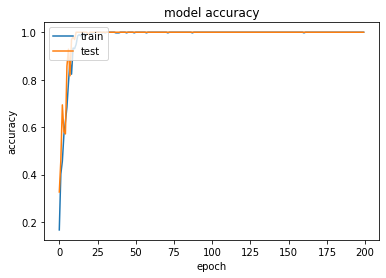

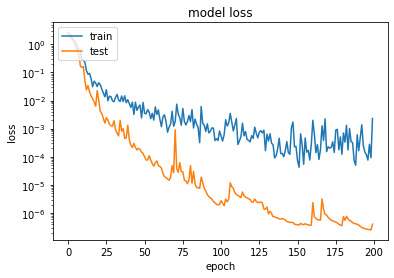

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

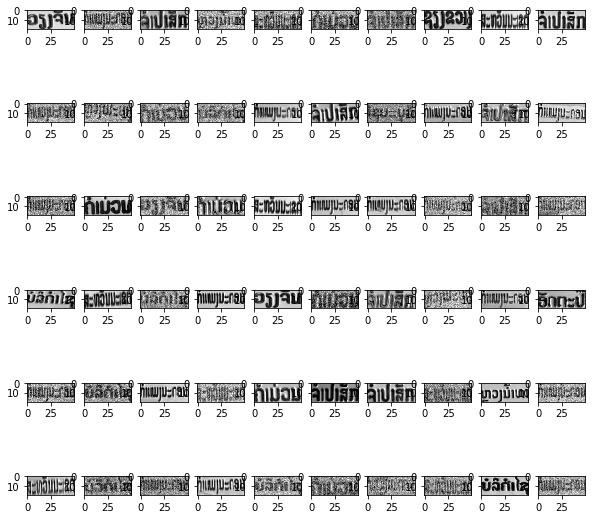

In [0]:
ncol = 10
nrow = 6

fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))

for r in range(nrow):
  for c in range(ncol):
    axs[r][c].imshow(x_test[r*ncol+c].reshape((20, 50)), cmap='gray')
plt.show()

In [0]:
#model.predict_classes(x_test)
print([ys[c] for c in model.predict_classes(x_test)])

['ວຽງຈັນ', 'ກຳແພງນະຄອນ', 'ຈຳປາສັກ', 'ຫຼວງນ້ຳທາ', 'ສະຫວັນນະເຂດ', 'ຄຳມ່ວນ', 'ຈຳປາສັກ', 'ຊຽງຂວາງ', 'ສະຫວັນນະເຂດ', 'ຈຳປາສັກ', 'ກຳແພງນະຄອນ', 'ຫຼວງພະບາງ', 'ຄຳມ່ວນ', 'ບໍລິຄຳໄຊ', 'ກຳແພງນະຄອນ', 'ຈຳປາສັກ', 'ໄຊຍະບູລີ', 'ກຳແພງນະຄອນ', 'ຈຳປາສັກ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ຄຳມ່ວນ', 'ວຽງຈັນ', 'ຄຳມ່ວນ', 'ສະຫວັນນະເຂດ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ຈຳປາສັກ', 'ກຳແພງນະຄອນ', 'ບໍລິຄຳໄຊ', 'ສະຫວັນນະເຂດ', 'ບໍລິຄຳໄຊ', 'ກຳແພງນະຄອນ', 'ວຽງຈັນ', 'ຄຳມ່ວນ', 'ຈຳປາສັກ', 'ຫຼວງພະບາງ', 'ກຳແພງນະຄອນ', 'ອັດຕະປື', 'ກຳແພງນະຄອນ', 'ບໍລິຄຳໄຊ', 'ກຳແພງນະຄອນ', 'ສະຫວັນນະເຂດ', 'ຄຳມ່ວນ', 'ຈຳປາສັກ', 'ຈຳປາສັກ', 'ສະຫວັນນະເຂດ', 'ຫຼວງນ້ຳທາ', 'ກຳແພງນະຄອນ', 'ສະຫວັນນະເຂດ', 'ບໍລິຄຳໄຊ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ບໍລິຄຳໄຊ', 'ຄຳມ່ວນ', 'ກຳແພງນະຄອນ', 'ສະຫວັນນະເຂດ', 'ບໍລິຄຳໄຊ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ສະຫວັນນະເຂດ', 'ກຳແພງນະຄອນ', 'ຫຼວງນ້ຳທາ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອນ', 'ໄຊຍະບູລີ', 'ບໍລິຄຳໄຊ', 'ໄຊຍະບູລີ', 'ກຳແພງນະຄອນ', 'ຄຳມ່ວນ', 'ກຳແພງນະຄອນ', 'ຫຼວງພະບາງ', 'ຄຳມ່ວນ', 'ສະຫວັນນະເຂດ', 'ຈຳປາສັກ', 'ຫຼວງພະບາງ', 'ກຳແພງນະຄອນ', 'ກຳແພງນະຄອ

In [0]:
y_test

array([ 7,  0,  2,  9,  8,  1,  2,  3,  8,  2,  0, 10,  1,  4,  0,  2, 12,
        0,  2,  0,  0,  1,  7,  1,  8,  0,  0,  0,  2,  0,  4,  8,  4,  0,
        7,  1,  2, 10,  0, 11,  0,  4,  0,  8,  1,  2,  2,  8,  9,  0,  8,
        4,  0,  0,  4,  1,  0,  8,  4,  0,  0,  8,  0,  9,  0,  0, 12,  4,
       12,  0,  1,  0, 10,  1,  8,  2, 10,  0,  0,  2, 10,  0,  2,  2,  2,
        0,  4,  4,  2,  0, 10,  8,  0,  8,  5,  0,  4,  9])

In [0]:
ys

['ກຳແພງນະຄອນ',
 'ຄຳມ່ວນ',
 'ຈຳປາສັກ',
 'ຊຽງຂວາງ',
 'ບໍລິຄຳໄຊ',
 'ບໍ່ແກ້ວ',
 'ຜົ້ງສາລິ',
 'ວຽງຈັນ',
 'ສະຫວັນນະເຂດ',
 'ຫຼວງນ້ຳທາ',
 'ຫຼວງພະບາງ',
 'ອັດຕະປື',
 'ໄຊຍະບູລີ']

In [0]:
y_predict = model.predict_classes(x_test)

indx_error = np.where(y_test!=y_predict)
indx_error

(array([], dtype=int64),)

In [0]:
test_err = y_test[indx_error]
prid_err = y_predict[indx_error]

plt.figure(figsize=(12, indx_error[0].shape[0]*14//4), dpi= 80, facecolor='w', edgecolor='k')
for i in range(indx_error[0].shape[0]):
    plt.subplot(int(indx_error[0].shape[0])+1,4,i+1)
    plt.imshow(x_test[indx_error[0][i]].reshape((50,50)), cmap='gray', interpolation='none')
    plt.title('target{}: predict{}'.format(ys[test_err[i]], ys[prid_err[i]]))

plt.show()

<Figure size 960x0 with 0 Axes>